In [ ]:
!pip install rdkit-pypi tdqm

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 36.8 MB 18 kB/s 
  Created wheel for tdqm: filename=tdqm-0.0.1-py3-none-any.whl size=1319 sha256=81ba6fe32d4524dff29f9c81ed38e872819510fd94b6f9847e007ab750235cef
  Stored in directory: /root/.cache/pip/wheels/c6/f0/d9/9fa5ff78c0f9d5a0a427bbbb4893c283520ddfccb885ea2205
Successfully built tdqm


# **Note**
This is a fork of [TechopenCADD repo](https://github.com/volkamerlab/teachopencadd), I adapted it for internal training only. 

In [ ]:
import os
!git clone https://github.com/TieuLongPhan/Database.git
os.chdir("/content/Database/Training_cheminformatics")

Mounted at /content/drive


In [ ]:
import time
import random
from pathlib import Path

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from rdkit.ML.Cluster import Butina
from rdkit.Chem import Descriptors, Draw, PandasTools
from rdkit.Chem import rdFingerprintGenerator
from rdkit.Chem.Fingerprints import FingerprintMols

from tqdm.auto import tqdm
tqdm.pandas()

In [ ]:
df = pd.read_csv("EGFR_compounds_lipinski.csv",
    usecols=["molecule_chembl_id", "smiles", "pIC50"],)
df.head(5)

,molecule_chembl_id,smiles,pIC50
0,CHEMBL63786,Brc1cccc(Nc2ncnc3cc4ccccc4cc23)c1,11.522879
1,CHEMBL35820,CCOc1cc2ncnc(Nc3cccc(Br)c3)c2cc1OCC,11.221849
2,CHEMBL53711,CN(C)c1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.221849
3,CHEMBL66031,Brc1cccc(Nc2ncnc3cc4[nH]cnc4cc23)c1,11.096910
4,CHEMBL53753,CNc1cc2c(Nc3cccc(Br)c3)ncnc2cn1,11.096910


In [ ]:
#df = df_all[df_all['pChEMBL Value'] >= 7]

# **0. Introduction to clustering and Jarvis-Patrick algorithm**

[Clustering](https://en.wikipedia.org/wiki/Cluster_analysis) can be defined as _the task of grouping a set of objects in such a way that objects in the same group (called a cluster) are more similar (in some sense) to each other than to those in other groups (clusters)_.

Compound clustering in pharmaceutical research is often based on chemical or structural similarity between compounds to find groups that share properties as well as to design a diverse and representative set for further analysis. 

General procedure: 

* Methods are based on clustering data by similarity between neighboring points. 
* In cheminformatics, compounds are often encoded as molecular fingerprints and similarity can be described by the Tanimoto similarity (see **Talktorial T004**).

> Quick reminder:
> 
>   * Fingerprints are binary vectors where each bit indicates the presence or absence of a particular substructural fragment within a molecule. 
>   * Similarity (or distance) matrix: The similarity between each pair of molecules represented by binary fingerprints is most frequently quantified using the Tanimoto coefficient, which measures the number of common features (bits). 
>   * The value of the Tanimoto coefficient ranges from zero (no similarity) to one (high similarity).

There are a number of clustering algorithms available, with the [Jarvis-Patrick clustering](http://www.improvedoutcomes.com/docs/WebSiteDocs/Clustering/Jarvis-Patrick_Clustering_Overview.htm) being one of the most widely used algorithms in the pharmaceutical context.

Jarvis-Patrick clustering algorithm is defined by two parameters $K$ and $K_{min}$:

* Calculate the set of $K$ nearest neighbors for each molecule. 
* Two molecules cluster together if 
    * they are in each others list of nearest neighbors
    * they have at least $K_{min}$ of their $K$ nearest neighbors in common.

The Jarvis-Patrick clustering algorithm is deterministic and able to deal with large sets of molecules in a matter of a few hours. However, a downside lies in the fact that this method tends to produce large heterogeneous clusters (see _Butina clustering_, referenced above). 

More clustering algorithms can also be found in the [scikit-learn clustering module](http://scikit-learn.org/stable/modules/clustering.html).

## Detailed explanation of Butina clustering

Butina clustering ([*J. Chem. Inf. Model.* (1999), **39** (4), 747](https://pubs.acs.org/doi/abs/10.1021/ci9803381)) was developed to identify smaller but homogeneous clusters, with the prerequisite that (at least) the cluster centroid will be more similar than a given threshold to every other molecule in the cluster.

These are the key steps in this clustering approach (see flowchart below):

#### 1. Data preparation and compound encoding

* To identify chemical similarities, the compounds in the input data (e.g. given as SMILES) will be encoded as molecular fingerprints, e.g., RDK5 fingerprint which is a subgraph-based fingerprint similar to the well known [Daylight Fingerprint](http://www.daylight.com/dayhtml/doc/theory/theory.finger.html) (which was used in the original publication).


#### 2. Tanimoto similarity (or distance) matrix

* The similarity between two fingerprints is calculated using the Tanimoto coefficient.
* Matrix with Tanimoto similarities between all possible molecule/fingerprint pairs ($n*n$ similarity matrix with $n$=number of molecules, upper triangle matrix used only).
* Equally, the distances matrix can be calculated ($1 - similarity$).

#### 3. Clustering molecules: Centroids and exclusion spheres 

> Note: Molecules will be clustered together, if they have a maximum distance below a specified cut-off from the cluster centroid (if distance matrix is used) or if they have a minimum similarity above the specified cut-off (if similarity matrix is used).  

* **Identification of potential cluster centroids**
    * The cluster centroid is the molecule within a given cluster which has the largest number of neighbors.
    * Annotate neighbors: For each molecule count all molecules with a Tanimoto distance below a given threshold.
    * Sort the molecules by their number of neighbors in descending order, so that potential cluster centroids (i.e. the compounds with the largest number of neighbors) are placed at the top of the file.  

* **Clustering based on the exclusion spheres**
    * Starting with the first molecule (centroid) in the sorted list.
        * All molecules with a Tanimoto index above or equal to the cut-off value used for clustering then become members of that cluster (in case of similarity).
            * Each molecule that has been identified as a member of the given cluster is flagged and removed from further comparisons. Thus, flagged molecules cannot become either another cluster centroid or a member of another cluster. This process is like putting an exclusion sphere around the newly formed cluster.
            * Once the first compound in the list has found all its neighbors, the first available (i.e. not flagged) compound at the top of the list becomes the new cluster centroid.
        * The same process is repeated for all other unflagged molecules down the list.
    * Molecules that have not been flagged by the end of the clustering process become singletons.
        * Note that some molecules assigned as singletons can have neighbors at the given Tanimoto similarity index, but those neighbors have been excluded by a stronger cluster centroid.

# **1. Similarity Matrix**

In [ ]:
# Create molecules from SMILES and store in array; .itertuples() returns a (index, column1, column2, ...) tuple per row
# we don't need index so we use _ instead
# note how we are slicing the dataframe to only the two columns we need now
compounds = []
for _, chembl_id, smiles in df[["molecule_chembl_id", "smiles"]].itertuples():
    mol = Chem.MolFromSmiles(smiles)
    mol.SetProp('_Name',chembl_id)
    compounds.append(mol)
compounds[:5]

In [ ]:
# Create fingerprints for all molecules
fingerprints = [AllChem.GetMorganFingerprintAsBitVect(mol, 2, nBits = 1024) for mol in compounds]

# How many compounds/fingerprints do we have?
print("Number of compounds converted:", len(fingerprints))
print("Fingerprint length per compound:", len(fingerprints[0]))
# NBVAL_CHECK_OUTPUT

Number of compounds converted: 4635
Fingerprint length per compound: 1024


In [ ]:
Test = compounds[:5]
fps= [AllChem.GetMorganFingerprintAsBitVect(mol, 1, nBits = 1024) for mol in Test]

size=len(Test)
hmap=np.empty(shape=(size,size))
table=pd.DataFrame()
for index, i in enumerate(fps):
    for jndex, j in enumerate(fps):
        similarity=DataStructs.FingerprintSimilarity(i,j, metric=DataStructs.TanimotoSimilarity)
        hmap[index,jndex]=similarity
        table.loc[Test[index].GetProp('_Name'),Test[jndex].GetProp('_Name')]=similarity

        
table.head()

,CHEMBL63786,CHEMBL35820,CHEMBL53711,CHEMBL66031,CHEMBL53753
CHEMBL63786,1.000000,0.708333,0.708333,0.772727,0.739130
CHEMBL35820,0.708333,1.000000,0.642857,0.629630,0.666667
CHEMBL53711,0.708333,0.642857,1.000000,0.629630,0.730769
CHEMBL66031,0.772727,0.629630,0.629630,1.000000,0.653846
CHEMBL53753,0.739130,0.666667,0.730769,0.653846,1.000000


# **2. Tanimoto distance matrix**

Now that we generated fingerprints, we move on to the next step: The identification of potential cluster centroids.  For this, we define functions to calculate the Tanimoto similarity and distance matrix.

In [ ]:
def tanimoto_distance_matrix(fp_list):
    """Calculate distance matrix for fingerprint list"""
    dissimilarity_matrix = []
    # Notice how we are deliberately skipping the first and last items in the list
    # because we don't need to compare them against themselves
    for i in range(1, len(fp_list)):
        # Compare the current fingerprint against all the previous ones in the list
        similarities = DataStructs.BulkTanimotoSimilarity(fp_list[i], fp_list[:i])
        # Since we need a distance matrix, calculate 1-x for every element in similarity matrix
        dissimilarity_matrix.extend([1 - x for x in similarities])
    return dissimilarity_matrix

In [ ]:
# Example: Calculate single similarity of two fingerprints
sim = DataStructs.TanimotoSimilarity(fingerprints[0], fingerprints[1])
print(f"Tanimoto similarity: {sim:.2f}, distance: {1-sim:.2f}")

Tanimoto similarity: 0.64, distance: 0.36


In [ ]:
# Example: Calculate distance matrix (distance = 1-similarity)
tanimoto_distance_matrix(fingerprints)[0:1]

[0.36170212765957444]

In [ ]:
# Side note: That looked like a list and not a matrix.
# But it is a triangular similarity matrix in the form of a list
n = len(fingerprints)

# Calculate number of elements in triangular matrix via n*(n-1)/2
elem_triangular_matr = (n * (n - 1)) / 2
print(
    f"Elements in the triangular matrix ({elem_triangular_matr:.0f}) ==",
    f"tanimoto_distance_matrix(fingerprints) ({len(tanimoto_distance_matrix(fingerprints))})",
)

Elements in the triangular matrix (10739295) == tanimoto_distance_matrix(fingerprints) (10739295)


# **3. Clustering molecules**

- Centroids and exclusion spheres
- In this part, we cluster the molecules and look at the results.

In [ ]:
def cluster_fingerprints(fingerprints, cutoff=0.2):
    """Cluster fingerprints
    Parameters:
        fingerprints
        cutoff: threshold for the clustering
    """
    # Calculate Tanimoto distance matrix
    distance_matrix = tanimoto_distance_matrix(fingerprints)
    # Now cluster the data with the implemented Butina algorithm:
    clusters = Butina.ClusterData(distance_matrix, len(fingerprints), cutoff, isDistData=True)
    clusters = sorted(clusters, key=len, reverse=True)
    return clusters

In [ ]:
# Run the clustering procedure for the dataset
clusters = cluster_fingerprints(fingerprints, cutoff=0.65)

# Give a short report about the numbers of clusters and their sizes
num_clust_g1 = sum(1 for c in clusters if len(c) == 1)
num_clust_g5 = sum(1 for c in clusters if len(c) > 5)
num_clust_g25 = sum(1 for c in clusters if len(c) > 25)
num_clust_g100 = sum(1 for c in clusters if len(c) > 100)

print("total # clusters: ", len(clusters))
print("# clusters with only 1 compound: ", num_clust_g1)
print("# clusters with >5 compounds: ", num_clust_g5)
print("# clusters with >25 compounds: ", num_clust_g25)
print("# clusters with >100 compounds: ", num_clust_g100)
# NBVAL_CHECK_OUTPUT

total # clusters:  323
# clusters with only 1 compound:  128
# clusters with >5 compounds:  106
# clusters with >25 compounds:  28
# clusters with >100 compounds:  7


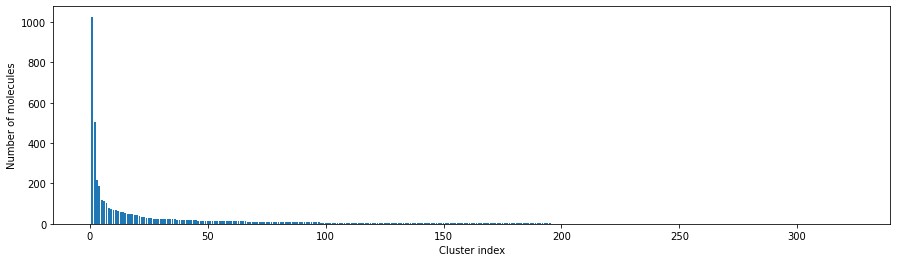

In [ ]:
# Plot the size of the clusters
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Number of molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5);

Since the clustering result depends on the threshold chosen by the user, we will have a closer look on the choice of a cutoff

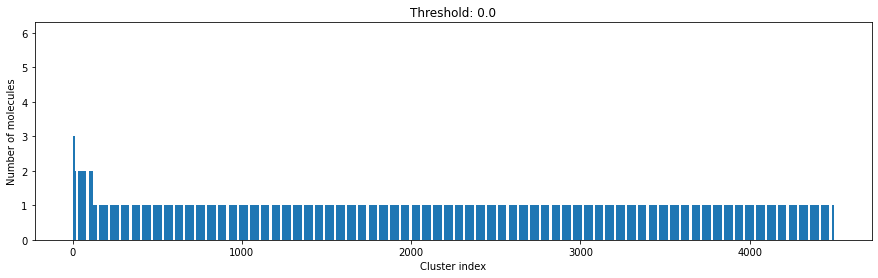

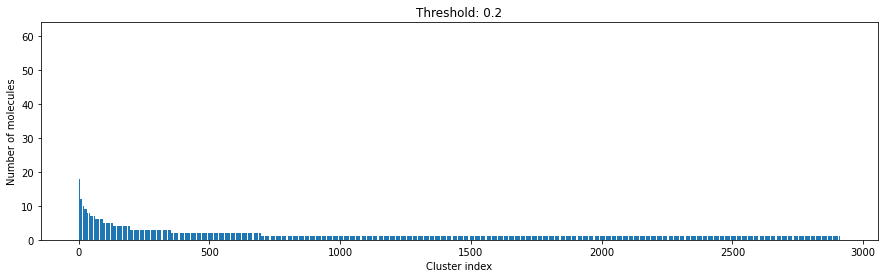

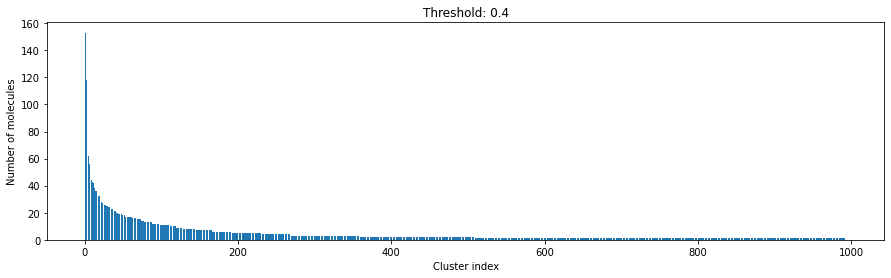

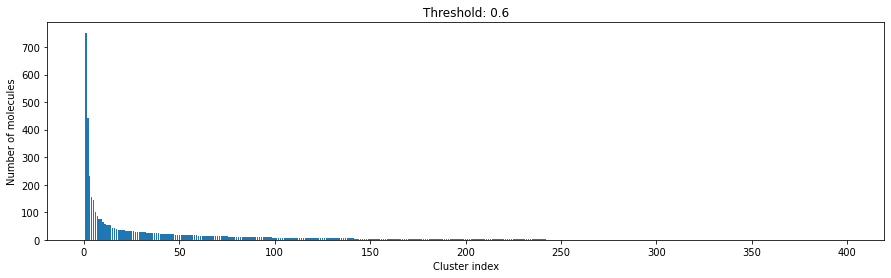

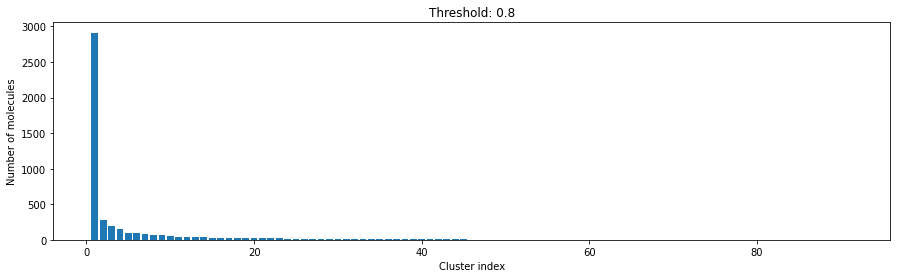

In [ ]:
for cutoff in numpy.arange(0.0, 1.0, 0.2):
    clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)
    fig, ax = plt.subplots(figsize=(15, 4))
    ax.set_title(f"Threshold: {cutoff:3.1f}")
    ax.set_xlabel("Cluster index")
    ax.set_ylabel("Number of molecules")
    ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters], lw=5)
    #display(fig)

As you can see, the higher the threshold (distance cutoff), the more molecules are considered as similar and, therefore, clustered into less clusters.
The lower the threshold, the more small clusters and "singletons" appear.

> The smaller the distance value cut-off, the more similar the compounds are required to be to belong to one cluster.

Looking at the plots above, we decided to choose a distance threshold of `0.2`. There are not many singletons and the cluster sizes don't have an extreme but smooth distribution.

Number of clusters: 259 from 4635 molecules at distance cut-off 0.70
Number of molecules in largest cluster: 1516
Similarity between two random points in same cluster: 0.30
Similarity between two random points in different cluster: 0.29


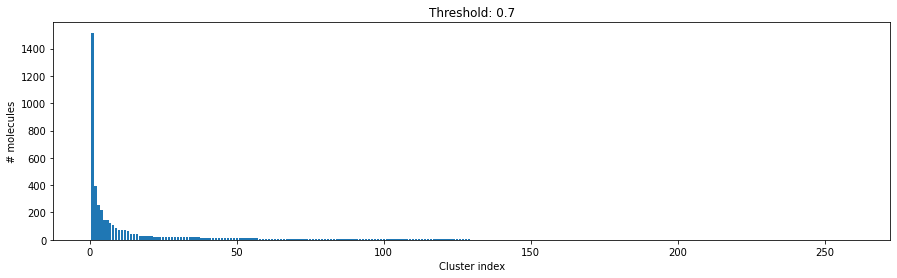

In [ ]:
cutoff = 0.7
clusters = cluster_fingerprints(fingerprints, cutoff=cutoff)

# Plot the size of the clusters - save plot
fig, ax = plt.subplots(figsize=(15, 4))
ax.set_xlabel("Cluster index")
ax.set_ylabel("# molecules")
ax.bar(range(1, len(clusters) + 1), [len(c) for c in clusters])
ax.set_title(f"Threshold: {cutoff:3.1f}")
fig.savefig(
    f"cluster_dist_cutoff_{cutoff:4.2f}.png",
    dpi=300,
    bbox_inches="tight",
    transparent=True,
)

print(
    f"Number of clusters: {len(clusters)} from {len(compounds)} molecules at distance cut-off {cutoff:.2f}"
)
print("Number of molecules in largest cluster:", len(clusters[0]))
print(
    f"Similarity between two random points in same cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[0][1]]):.2f}"
)
print(
    f"Similarity between two random points in different cluster: {DataStructs.TanimotoSimilarity(fingerprints[clusters[0][0]], fingerprints[clusters[1][0]]):.2f}"
)

Ten molecules from largest cluster:


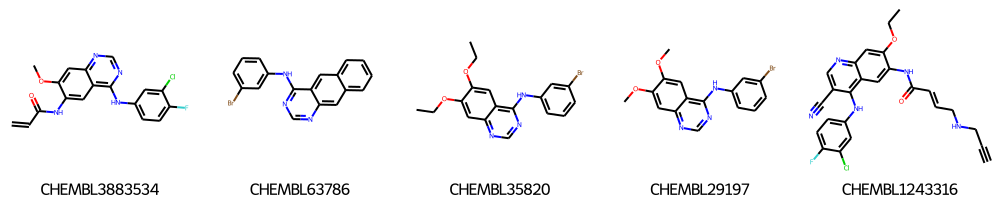

In [ ]:
print("Ten molecules from largest cluster:")
# Draw molecules
Draw.MolsToGridImage(
    [compounds[i] for i in clusters[0][:5]],
    legends=[compounds[i].GetProp('_Name') for i in clusters[0][:10]],
    molsPerRow=5,
)

In [ ]:
def intra_tanimoto(fps_clusters):
    """Function to compute Tanimoto similarity for all pairs of fingerprints in each cluster"""
    intra_similarity = []
    # Calculate intra similarity per cluster
    for cluster in fps_clusters:
        # Tanimoto distance matrix function converted to similarity matrix (1-distance)
        intra_similarity.append([1 - x for x in tanimoto_distance_matrix(cluster)])
    return intra_similarity

# Recompute fingerprints for 10 first clusters
mol_fps_per_cluster = []
for cluster in clusters[:5]:
    mol_fps_per_cluster.append([AllChem.GetMorganFingerprintAsBitVect(compounds[i], 1, nBits = 1024) for i in cluster])

# Compute intra-cluster similarity
intra_sim = intra_tanimoto(mol_fps_per_cluster)

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))
/usr/local/lib/python3.7/dist-packages/numpy/core/fromnumeric.py:1970: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  result = asarray(a).shape


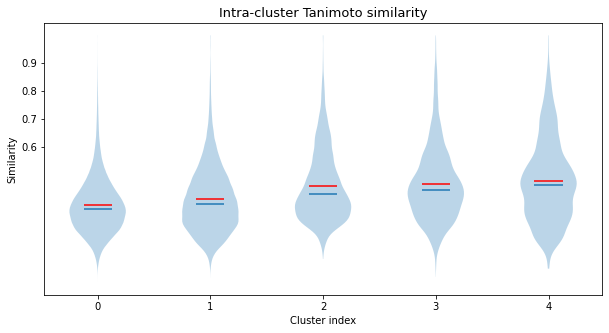

In [ ]:
# Violin plot with intra-cluster similarity

fig, ax = plt.subplots(figsize=(10, 5))
indices = list(range(5))
ax.set_xlabel("Cluster index")
ax.set_ylabel("Similarity")
ax.set_xticks(indices)
ax.set_xticklabels(indices)
ax.set_yticks(numpy.arange(0.6, 1.0, 0.1))
ax.set_title("Intra-cluster Tanimoto similarity", fontsize=13)
r = ax.violinplot(intra_sim, indices, showmeans=True, showmedians=True, showextrema=False)
r["cmeans"].set_color("red")
# mean=red, median=blue

In [ ]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
data = pd.DataFrame(cluster_centers, columns = ['Mol'])

Number of cluster centers: 14


In [ ]:
fps= [AllChem.GetMorganFingerprintAsBitVect(mol, 1, nBits = 1024) for mol in cluster_centers]

In [ ]:
import numpy as np
size=len(cluster_centers)
hmap=np.empty(shape=(size,size))
table=pd.DataFrame()
for index, i in enumerate(fps):
    for jndex, j in enumerate(fps):
        similarity=DataStructs.FingerprintSimilarity(i,j, metric=DataStructs.TanimotoSimilarity)
        hmap[index,jndex]=similarity
        table.loc[cluster_centers[index].GetProp('_Name'),cluster_centers[jndex].GetProp('_Name')]=similarity

In [ ]:
table

,CHEMBL1914559,CHEMBL148241,CHEMBL2206770,CHEMBL437361,CHEMBL1773409,CHEMBL272420,CHEMBL3415845,CHEMBL272419,CHEMBL512021,CHEMBL4568499,CHEMBL405927,CHEMBL1082257,CHEMBL261703,CHEMBL560387
CHEMBL1914559,1.000000,0.295455,0.285714,0.270833,0.298246,0.186441,0.295455,0.195652,0.282609,0.244444,0.215686,0.208955,0.148148,0.098361
CHEMBL148241,0.295455,1.000000,0.220000,0.250000,0.166667,0.229167,0.277778,0.257143,0.297297,0.250000,0.243902,0.228070,0.243902,0.142857
CHEMBL2206770,0.285714,0.220000,1.000000,0.203704,0.238095,0.254237,0.297872,0.156863,0.260000,0.250000,0.269231,0.148649,0.178571,0.163934
CHEMBL437361,0.270833,0.250000,0.203704,1.000000,0.116667,0.145455,0.162791,0.297297,0.209302,0.289474,0.250000,0.213115,0.170213,0.090909
CHEMBL1773409,0.298246,0.166667,0.238095,0.116667,1.000000,0.187500,0.285714,0.129630,0.250000,0.127273,0.133333,0.144737,0.114754,0.158730
CHEMBL272420,0.186441,0.229167,0.254237,0.145455,0.187500,1.000000,0.156863,0.163265,0.244898,0.183673,0.207547,0.136986,0.142857,0.095238
CHEMBL3415845,0.295455,0.277778,0.297872,0.162791,0.285714,0.156863,1.000000,0.189189,0.230769,0.153846,0.214286,0.147541,0.186047,0.120000
CHEMBL272419,0.195652,0.257143,0.156863,0.297297,0.129630,0.163265,0.189189,1.000000,0.210526,0.228571,0.289474,0.192982,0.225000,0.080000
CHEMBL512021,0.282609,0.297297,0.260000,0.209302,0.250000,0.244898,0.230769,0.210526,1.000000,0.236842,0.261905,0.200000,0.177778,0.160000
CHEMBL4568499,0.244444,0.250000,0.250000,0.289474,0.127273,0.183673,0.153846,0.228571,0.236842,1.000000,0.282051,0.112903,0.190476,0.078431


# **4. Picking diverse compounds**

Finding representative sets of compounds is a concept often used in pharmaceutical industry.

* Let's say, we applied a virtual screening campaign but only have a limited amount of resources to experimentally test a few compounds in a confirmatory assay.  
* In order to obtain as much information as possible from this screen, we want to select a diverse set. Thus, we pick one representative of each chemical series in our list of potentially active compounds.

Another scenario would be to select one series to gain information about the structure-activity relationship; i.e., how small structural changes in the molecule affect the _in vitro_ activity.

### Picking the final list of compounds

In the following, we are going to pick a final list of **max. 1000 compounds** as a **diverse** subset. 

For this, we take the cluster centroid from each cluster (i.e. the first molecule of each cluster) and then for each cluster (starting with the largest one) we take the 10 molecules (or 50% if less than 10 molecules are left in the cluster) that are most similar to the centroid, until we have selected max. 1000 compounds. Thus, we have representatives of each cluster. 

Aim of this compound picking is to ensure the diversity for a smaller set of compounds which are proposed for testing in a confirmatory assay. 

> Picking procedure was adapted from [TDT tutorial notebook by S. Riniker and G. Landrum](https://github.com/sriniker/TDT-tutorial-2014/blob/master/TDT_challenge_tutorial.ipynb). 

As described there: the idea behind this approach is to ensure diversity (representatives of each cluster) while getting some SAR (structure-activity relationship) from the results of the confirmatory assay (groups of quite similar molecules from larger clusters retained).

In [ ]:
# Get the cluster center of each cluster (first molecule in each cluster)
cluster_centers = [compounds[c[0]] for c in clusters]
# How many cluster centers/clusters do we have?
print("Number of cluster centers:", len(cluster_centers))
# NBVAL_CHECK_OUTPUT

Number of cluster centers: 259


In [ ]:
compounds

 ...]

Sort clusters by size and molecules in each cluster by similarity.

In [ ]:
# Sort the molecules within a cluster based on their similarity
# to the cluster center and sort the clusters based on their size
sorted_clusters = []
for cluster in clusters:
    if len(cluster) <= 1:
        continue  # Singletons
    # else:
    # Compute fingerprints for each cluster element
    #sorted_fingerprints = [rdkit_gen.GetFingerprint(compounds[i][0]) for i in cluster]
    sorted_fingerprints= [AllChem.GetMorganFingerprintAsBitVect(compounds[i], 1, nBits = 1024) for i in cluster]
    # Similarity of all cluster members to the cluster center
    similarities = DataStructs.BulkTanimotoSimilarity(
        sorted_fingerprints[0], sorted_fingerprints[1:]
    )
    # Add index of the molecule to its similarity (centroid excluded!)
    similarities = list(zip(similarities, cluster[1:]))
    # Sort in descending order by similarity
    similarities.sort(reverse=True)
    # Save cluster size and index of molecules in clusters_sort
    sorted_clusters.append((len(similarities), [i for _, i in similarities]))
    # Sort in descending order by cluster size
    sorted_clusters.sort(reverse=True)

In [ ]:

len(sorted_clusters)

158

In [ ]:
# Count selected molecules, pick cluster centers first
selected_molecules = cluster_centers.copy()
# Take 10 molecules (or a maximum of 50%) of each cluster starting with the largest one
index = 0
pending = 500 - len(selected_molecules)
while pending > 0 and index < len(sorted_clusters):
    # Take indices of sorted clusters
    tmp_cluster = sorted_clusters[index][1]
    # If the first cluster is > 10 big then take exactly 10 compounds
    if sorted_clusters[index][0] > 10:
        num_compounds = 10
    # If smaller, take half of the molecules
    else:
        num_compounds = int(0.5 * len(tmp_cluster)) + 1
    if num_compounds > pending:
        num_compounds = pending
    # Write picked molecules and their structures into list of lists called picked_fps
    selected_molecules += [compounds[i] for i in tmp_cluster[:num_compounds]]
    index += 1
    pending = 28 - len(selected_molecules)
print("# Selected molecules:", len(selected_molecules))
# NBVAL_CHECK_OUTPUT

# Selected molecules: 259
